In [1]:
from enum import Enum, auto

import torch
from torch import nn
from tqdm import tqdm
from torch.optim import SGD
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.model import AlexNet
from src.data_loader import DataLoaderCIFAR10
from src.train import TrainModel

import random
import matplotlib.pyplot as plt

In [2]:
class Labels(Enum):
    airplane = 0
    automobile  = auto()
    bird = auto()
    cat = auto()
    deer = auto()
    dog = auto()
    frog = auto()
    horse = auto()
    ship = auto()
    truck = auto()

    @classmethod
    def get_key(cls, value: int) -> str:
        return cls(value).name

In [3]:
def show_results(batch: list, mean: list, std: list):
    n_images = len(batch[0])
    _, axes = plt.subplots(nrows = n_images, ncols = 2, figsize=(10, 12))

    for i in range(n_images):
        img = batch[0][i].to("cpu")
        img = denormalize_img(img, mean, std)
        img = (img.permute(1,2,0) * 255).type(torch.uint8)

        y_true = batch[1][i].to("cpu")
        pred_scores = batch[2][i].to("cpu")
        
        pred_scores, preds_class = get_classes(pred_scores)
        y_pred = torch.argmax(pred_scores)

        axes[i, 0].imshow(img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"{ Labels.get_key(int(y_true)) } \n Pred: { Labels.get_key(int(y_pred)) }")

        axes[i, 1].barh(list(preds_class.keys())[:5], list(preds_class.values())[:5])
        axes[i, 1].set_xlim(0, 1)

    plt.tight_layout()

def denormalize_img(img: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    mean_tensor = torch.tensor(mean).view(3, 1, 1)
    std_tensor = torch.tensor(std).view(3, 1, 1)
    return mean_tensor + img * std_tensor

def get_classes(scores: torch.Tensor) -> tuple[torch.Tensor, dict]:
    scores = torch.softmax(scores, 0)
    preds_class = {Labels.get_key(pred): float(scores[pred]) for pred in range(len(scores))}
    preds_class = dict(sorted(preds_class.items(), key = lambda x: x[1], reverse = True))
    return scores, preds_class


In [4]:
cifar = DataLoaderCIFAR10(32, 4)
trainset, testset = cifar.get_loaders()

model = AlexNet(10)
train = TrainModel(model, 30, 1e-4, 0.9, 5e-4)

In [5]:
train.train(trainset)

Epoch: 29, Loss: 0.3469, Accuracy: 0.8788: 100%|██████████| 30/30 [28:12<00:00, 56.41s/it]


In [6]:
results = train.eval(testset, True)

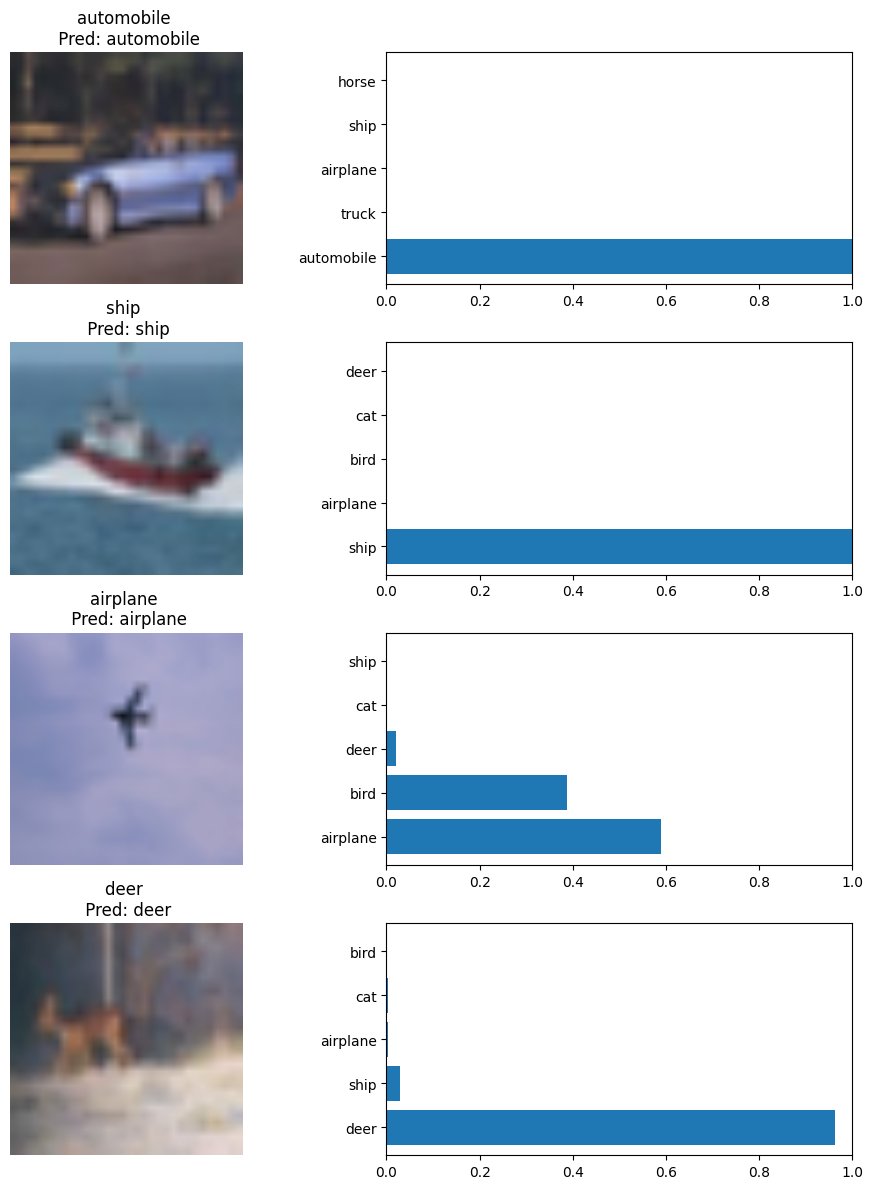

In [7]:
show_results(random.choice(results), cifar.mean, cifar.std)